# BloodBowlRL - Stable 3





### Imports

In [1]:
from enum import Enum
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as timeStep

from tf_agents.policies import random_tf_policy

from tf_agents.metrics import tf_py_metric
from tf_agents.metrics import tf_metrics
from tf_agents.metrics import py_metric
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer

from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.policies import policy_saver

In [2]:
def column(matrix, i):
    return [row[i] for row in matrix]

### Game Environment

In [3]:
class ActionResult(Enum):
    VALID_MOVE = 1
    ILLEGAL_MOVE = 2
    FOUND_BALL = 3
    FOUND_ENEMY = 4
    GAME_COMPLETE_WITH_BALL = 6

In [4]:
#class GameData(Enum):
PITCH_SIZE = 15
PLAYER_TOKEN = 1
ENEMY_TOKEN = 2
BALL_TOKEN = 3
EMPTY_TOKEN = 0
MOVE_LEFT = -1
MOVE_RIGHT = 1
MOVE_UP = PITCH_SIZE
MOVE_DOWN = - PITCH_SIZE
REWARD_TOCHDOWN = 100
REWARD_GET_BALL = 10
REWARD_ENEMY = -0.5
REWARD_TRANSITION = -0.3
REWARD_ILLEGAL_MOVE = -10


In [5]:
ball_location = [124]
enemy_locations = [48,158,106,36,191,61]
initial_player_location = 4

In [6]:
class AlphaBowl():
    def __init__(self, ball_location, enemy_locations, initial_player_location):
        self._state = np.zeros((PITCH_SIZE * PITCH_SIZE,),dtype=np.int32)
        self._enemy_locations = enemy_locations
        self._ball_location = ball_location
        self._state[self._enemy_locations] = ENEMY_TOKEN
        self._state[self._ball_location] = BALL_TOKEN
        self._state[initial_player_location] = PLAYER_TOKEN
        self._carriyng_ball = False
        self._game_ended = False

    
    def update_enemy_locations (enemy_locations):
        self._enemy_locations = enemy_locations
    
    def reset(self):
        self._state = np.zeros((PITCH_SIZE*PITCH_SIZE,),dtype=np.int32)
        self._state[self._enemy_locations] = ENEMY_TOKEN
        self._state[self._ball_location] = BALL_TOKEN
        self._state[initial_player_location] = PLAYER_TOKEN
        self._carriyng_ball = False
        self._game_ended = False

    def __is_spot_last(self, position):
        return (  ((position + 1) % PITCH_SIZE == 0)   or ((position) % PITCH_SIZE == 0))

    
    def __is_carrying_ball(self):
        return self._carriyng_ball

    def move_player(self, current_position, next_position):

        if (self.__is_spot_last(next_position)):
        
            self._state[current_position] = EMPTY_TOKEN
            self._state[next_position] = PLAYER_TOKEN
            self._game_ended = True
            if(self.__is_carrying_ball()):
                return ActionResult.GAME_COMPLETE_WITH_BALL

        if next_position < 0 or next_position > (len(self._state) - 1):
            self._game_ended = True
            return ActionResult.ILLEGAL_MOVE

        if self._state[next_position] == ENEMY_TOKEN:
            self._game_ended = True
            return ActionResult.FOUND_ENEMY

        if self._state[next_position] == BALL_TOKEN:
            self._state[current_position] = EMPTY_TOKEN
            self._state[next_position] = PLAYER_TOKEN
            self._carriyng_ball = True
            return ActionResult.FOUND_BALL

        self._state[current_position] = EMPTY_TOKEN
        self._state[next_position] = PLAYER_TOKEN

        return ActionResult.VALID_MOVE

    def game_ended(self):
        return self._game_ended
  
    def game_state(self):
        return self._state

In [7]:
class AlphaBowlEnvironment(py_environment.PyEnvironment):

    def __init__(self, game):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(PITCH_SIZE * PITCH_SIZE,), dtype=np.int32, minimum=0, maximum=3, name='observation')

        
        self._action_values = {0:MOVE_LEFT,
                               1:MOVE_RIGHT,
                               2:MOVE_DOWN,
                               3:MOVE_UP}
        self._game = game

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._game.reset()
        return timeStep.restart(self._game.game_state())
  
    def _step(self, action):    

        if self._game.game_ended():
            return self.reset()

        action = action.item()

        next_agent_position_direction = self._action_values.get(action)
        current_agent_position = np.where(self._game.game_state() == PLAYER_TOKEN)[0].item()
        new_agent_position = current_agent_position + next_agent_position_direction

        response = self._game.move_player(current_agent_position,new_agent_position)

        
        if response == ActionResult.GAME_COMPLETE_WITH_BALL:
            return timeStep.termination(self._game.game_state(), REWARD_TOCHDOWN)

        elif response == ActionResult.ILLEGAL_MOVE:
            return timeStep.termination(self._game.game_state(), REWARD_ILLEGAL_MOVE)

        elif response == ActionResult.FOUND_ENEMY:
            return timeStep.termination(self._game.game_state(), REWARD_ENEMY)

        elif response == ActionResult.FOUND_BALL:
            return timeStep.transition(self._game.game_state(), reward=REWARD_GET_BALL, discount=1.5)

        return timeStep.transition(self._game.game_state(), reward=REWARD_TRANSITION, discount=1.0)

In [8]:
bowlEnvironment = AlphaBowlEnvironment(AlphaBowl(ball_location, enemy_locations, initial_player_location))
utils.validate_py_environment(bowlEnvironment, episodes=5)

In [9]:
train_env = tf_py_environment.TFPyEnvironment(bowlEnvironment)
eval_env = tf_py_environment.TFPyEnvironment(bowlEnvironment)

### DQN Setup

In [10]:
fc_layer_params = [32,64,128,256,512]

q_net = q_network.QNetwork(
            train_env.observation_spec(),
            train_env.action_spec(),
            fc_layer_params = fc_layer_params
        )

train_step = tf.Variable(0)
update_period = 4
optimizer = tf.keras.optimizers.Adam(lr=2.5e-4, epsilon=0.00001)

epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                initial_learning_rate=1.0, 
                decay_steps=250000 // update_period,
                end_learning_rate=0.01)

agent = dqn_agent.DdqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        target_update_period=2000,
        td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
        gamma=0.99,
        train_step_counter=train_step,
        epsilon_greedy=lambda: epsilon_fn(train_step))

agent.initialize()

### Replay Buffer Setup

In [11]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=1000000)

replay_buffer_observer = replay_buffer.add_batch

### Metrics Setup

In [12]:
train_metrics = [tf_metrics.AverageReturnMetric(), tf_metrics.AverageEpisodeLengthMetric()]

### Driver Setup

In [13]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period)

### Collect trajectories using Random Policy

In [14]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [15]:
initial_collect_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

init_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(30000)],
    num_steps=30000)

final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


30000/30000

### Verify collected trajectories

In [16]:
trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2, num_steps=10)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [17]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [18]:
time_steps, action_steps, next_time_steps = trajectory.to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 9, 225])

### Create Dataset from Replay Buffer

In [19]:
dataset = replay_buffer.as_dataset(sample_batch_size=500, num_steps=2, num_parallel_calls=3).prefetch(3)

### Run it under common function to make it faster

In [20]:
collect_driver.run = common.function(collect_driver.run)
agent.train = common.function(agent.train)

### Train

In [21]:
all_train_loss = []
all_metrics = []

In [22]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    
    for iteration in range(n_iterations):
        current_metrics = []
        
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)
        all_train_loss.append(train_loss.loss.numpy())

        for i in range(len(train_metrics)):
            current_metrics.append(train_metrics[i].result().numpy())
            
        all_metrics.append(current_metrics)
        
        if iteration % 500 == 0:
            print("\nIteration: {}, loss:{:.2f}".format(iteration, train_loss.loss.numpy()))
            
            for i in range(len(train_metrics)):
                print('{}: {}'.format(train_metrics[i].name, train_metrics[i].result().numpy()))

In [23]:
#train_agent(50000)
train_agent(35000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))



Iteration: 0, loss:0.70
AverageReturn: 0.0
AverageEpisodeLength: 0.0

Iteration: 500, loss:0.22
AverageReturn: -10.629999160766602
AverageEpisodeLength: 3.0999999046325684

Iteration: 1000, loss:0.29
AverageReturn: -7.069999694824219
AverageEpisodeLength: 3.9000000953674316

Iteration: 1500, loss:0.24
AverageReturn: -10.65999984741211
AverageEpisodeLength: 4.699999809265137

Iteration: 2000, loss:0.24
AverageReturn: -11.380000114440918
AverageEpisodeLength: 15.300000190734863

Iteration: 2500, loss:0.13
AverageReturn: -9.320000648498535
AverageEpisodeLength: 11.399999618530273

Iteration: 3000, loss:0.17
AverageReturn: -9.979999542236328
AverageEpisodeLength: 4.099999904632568

Iteration: 3500, loss:0.17
AverageReturn: -8.899999618530273
AverageEpisodeLength: 10.0

Iteration: 4000, loss:0.19
AverageReturn: -10.89000129699707
AverageEpisodeLength: 11.0

Iteration: 4500, loss:0.26
AverageReturn: -8.5
AverageEpisodeLength: 5.5

Iteration: 5000, loss:0.15
AverageReturn: -10.78999996185302

In [24]:
avg_return_trained = column(all_metrics,0)
avg_ep_trained = column(all_metrics,1)

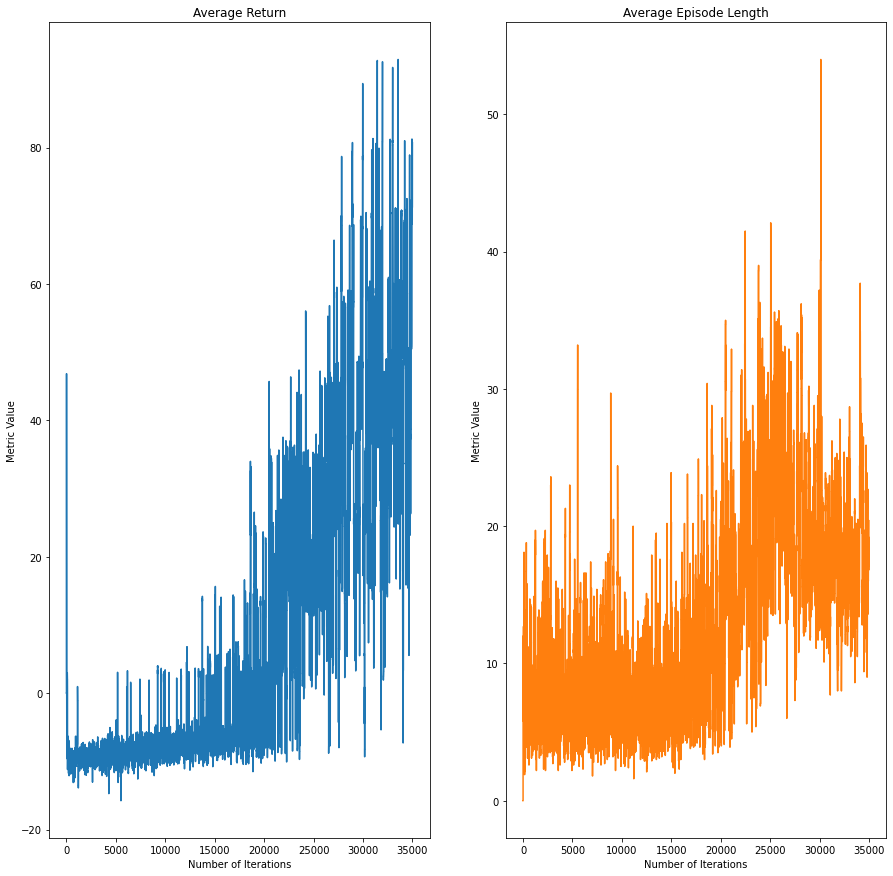

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))

axs[0].plot(range(len(avg_return_trained)), avg_return_trained)
axs[0].set_title('Average Return')

axs[1].plot(range(len(avg_ep_trained)), avg_ep_trained, 'tab:orange')
axs[1].set_title('Average Episode Length')

for ax in axs.flat:
    ax.set(xlabel='Number of Iterations', ylabel='Metric Value')

### Evaluate

In [26]:
def compute_avg_return(environment, policy, num_episodes=15):

    total_return = 0.0
    
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        
        total_return += episode_return

    avg_return = total_return / num_episodes
    
    return avg_return.numpy()[0]

In [27]:
# Reset the train step
agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [28]:
#reset eval environment
eval_env.reset()

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 225), dtype=int32, numpy=
array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [29]:
# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, 15)

In [30]:
avg_return

107.0

### Visualize Episode

In [31]:
def observation_viz(observation):
    numpy_obs = observation.numpy()[0]
    string_obs = np.array(np.reshape(numpy_obs, (-1, PITCH_SIZE)), dtype=np.unicode_)
    
    for i in range(0, PITCH_SIZE): 
        if (string_obs[i][PITCH_SIZE - 1]) != str(PLAYER_TOKEN):
            string_obs[i][PITCH_SIZE - 1] = "🏁"
        if (string_obs[i][0]) != str(PLAYER_TOKEN):
            string_obs[i][0] = "🏁"  

    string_obs = np.where(string_obs == str(PLAYER_TOKEN),"👦", string_obs) 
    string_obs = np.where(string_obs == str(ENEMY_TOKEN),"☠️", string_obs)
    string_obs = np.where(string_obs == str(BALL_TOKEN),"🏈", string_obs)
    string_obs = np.where(string_obs == str(EMPTY_TOKEN),"🟩", string_obs)
    observe_2d = pd.DataFrame(string_obs)
    observe_2d.columns = [''] * len(observe_2d.columns)
    observe_2d = observe_2d.to_string(index=False)
    print("\n{}\n".format(observe_2d))

In [32]:
def compute_viz(environment, policy, num_episodes=100):

    total_return = 0.0
    
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        step = 0
        print("Step: 0")
        observation_viz(time_step.observation)
        while not time_step.is_last():
            step += 1
            print("---\nStep: {}".format(step))
            action_step = policy.action(time_step)
            print("Action taken: {}".format(action_step.action))
            time_step = environment.step(action_step.action)
            observation_viz(time_step.observation)
            episode_return += time_step.reward
            print("Reward: {} \n".format(episode_return))
            print("Press ENTER for next step")
            input()
        total_return += episode_return

    avg_return = total_return / num_episodes
    
    return avg_return.numpy()[0]

In [35]:
# Reset the train step
agent.train_step_counter.assign(0)

#reset eval environment
eval_env.reset()

# Evaluate the agent's policy once before training.
avg_return = compute_viz(eval_env, agent.policy, 1)

Step: 0

                                                 
 🏁   🟩  🟩   🟩  👦  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩  ☠️  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩  ☠️  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁  ☠️  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁  ☠️  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🏈  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩  ☠️  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩  ☠️  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁

---
Step: 1
Action taken: [3]

                                                 
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  👦  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩


---
Step: 8
Action taken: [3]

                                                 
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩  ☠️  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩  ☠️  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁  ☠️  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁  ☠️  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  👦  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩  ☠️  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩  ☠️  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩  🟩  🏁

Reward: [7.9] 

Press ENTER for next step

---
Step: 9
Action taken: [0]

                                                 
 🏁   🟩  🟩   🟩  🟩  🟩   🟩  🟩   🟩  🟩  🟩   🟩  🟩

Algoritmo general - Juego por turnos
1. Generar estado del juego
2. Entrenar y ejecutar un numero de pasos igual al MA
3. Exportar estado